# Running a default CNN model on Fashion MNIST dataset to benchmark it's accuracy


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

seed = 42
random.seed(seed)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)  # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(
    train_dataloader,
    valid_dataloader,
    PATH,
    model=None,
    criterion=F.cross_entropy,
    epochs=1,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = criterion(pred_prob, y)  # nll is the negative likelihood loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print(
                    "epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}".format(
                        epoch,
                        b_i,
                        len(train_dataloader),
                        100.0 * b_i / len(train_dataloader),
                        loss.item(),
                    )
                )

        train_losses.append(losses / len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(
                    pred_prob, y, reduction="sum"
                ).item()  # loss summed across the batch
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100.0 * success / len(valid_dataloader.dataset)

        if accuracy > best_acc:
            torch.save(model.state_dict(), PATH)
            best_acc = accuracy

        print(
            "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
                loss, success, len(valid_dataloader.dataset), accuracy
            )
        )
    return model, train_losses, val_losses


def test(model, PATH, criterion=F.cross_entropy):
    model.eval()
    model.load_state_dict(torch.load(PATH))
    loss = 0
    success = 0
    correct = 0
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += criterion(
                pred_prob, y, reduction="sum"
            ).item()  # loss summed across the batch
            pred = pred_prob.argmax(
                dim=1, keepdim=True
            )  # use argmax to get the most likely prediction
            correct = np.squeeze(pred.eq(y.view_as(pred)))
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    accuracy = 100.0 * success / len(test_dataloader.dataset)

    print(
        "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
            loss, success, len(test_dataloader.dataset), accuracy
        )
    )

    for i in range(len(y)):
        label = y[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    class_percentages = []
    for i in range(len(class_correct)):
        class_percentages.append(class_correct[i] / class_total[i])

    return accuracy, class_percentages

## Orignal Fasion Mnist Dataset Class distribution

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Distribution of classes in original dataset:


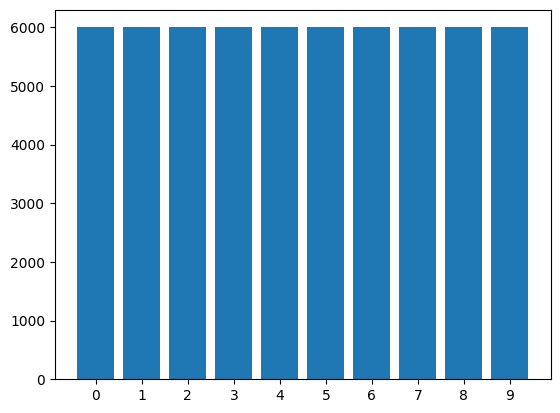

In [ ]:
trainset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)
print(Counter(trainset.targets.numpy()))

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.seed(seed)
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
train_dataloader = torch.utils.data.DataLoader(
    trainset, sampler=train_sample, batch_size=64
)
valid_dataloader = torch.utils.data.DataLoader(
    trainset, sampler=valid_sample, batch_size=64
)

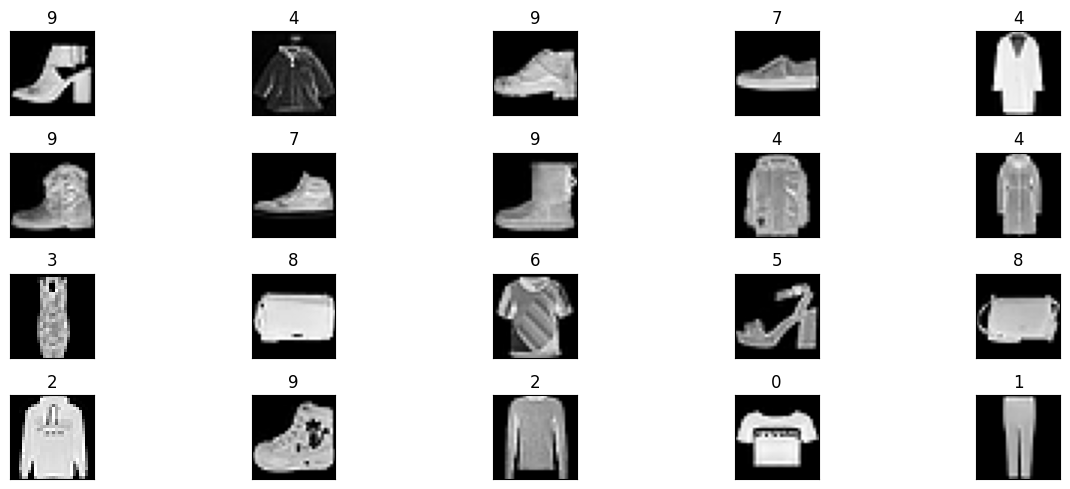

In [ ]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
    # xticks=[], yticks=[] is empty to print the images without any ticks around them
    # np.sqeeze : Remove single-dimensional entries from the shape of an array.
    ax = fig.add_subplot(4, int(20 / 4), idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    # .item() gets the value contained in a Tensor
    ax.set_title(labels[idx].item())
    fig.tight_layout()

In [ ]:
test_ds = datasets.FashionMNIST(
    "../data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

# Balanced/Orignal Dataset Training

In [ ]:
model, train_losses, val_losses = train(
    train_dataloader,
    valid_dataloader,
    "Balanced_model.pth",
    ConvNet().to(device),
    epochs=10,
)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/188 (0%)]	 training loss: 2.335207
epoch: 0 [10/188 (5%)]	 training loss: 1.951526
epoch: 0 [20/188 (11%)]	 training loss: 1.172688
epoch: 0 [30/188 (16%)]	 training loss: 0.701247
epoch: 0 [40/188 (21%)]	 training loss: 0.831044
epoch: 0 [50/188 (27%)]	 training loss: 1.008214
epoch: 0 [60/188 (32%)]	 training loss: 0.924344
epoch: 0 [70/188 (37%)]	 training loss: 0.618850
epoch: 0 [80/188 (43%)]	 training loss: 0.822094
epoch: 0 [90/188 (48%)]	 training loss: 0.571909
epoch: 0 [100/188 (53%)]	 training loss: 0.569874
epoch: 0 [110/188 (59%)]	 training loss: 0.599801
epoch: 0 [120/188 (64%)]	 training loss: 0.868455
epoch: 0 [130/188 (69%)]	 training loss: 0.655511
epoch: 0 [140/188 (74%)]	 training loss: 0.699716
epoch: 0 [150/188 (80%)]	 training loss: 0.727602
epoch: 0 [160/188 (85%)]	 training loss: 0.626556
epoch: 0 [170/188 (90%)]	 training loss: 0.560292
epoch: 0 [180/188 (96%)]	 training loss: 0.645553


Validation...

Test dataset: Overall Loss: 0.4315, Overall Ac

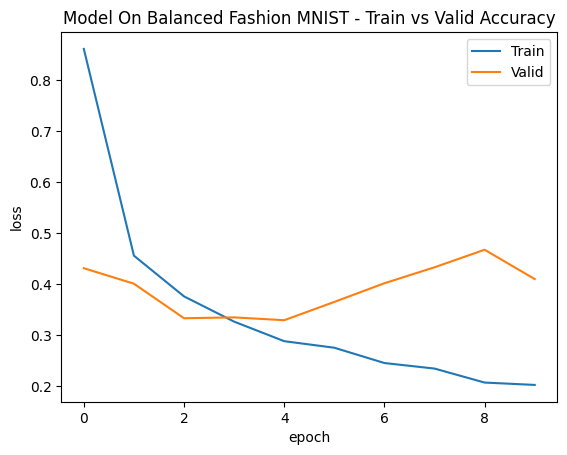

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On Balanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

# Test Model

In [ ]:
print("On vanilla Fashion MNIST dataset")
test_acc, _ = test(model, "Balanced_model.pth")
print("test accuracy : ", str(test_acc))

On vanilla Fashion MNIST dataset

Test dataset: Overall Loss: 0.5784, Overall Accuracy: 8554/10000 (86%)

test accuracy :  85.54


# Performance of the Model on Imbalanced Fashion MNIST Dataset

### Create Imbalanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({3: 5731, 8: 5627, 1: 5497, 0: 5312, 7: 4777, 5: 3579, 2: 2291, 4: 2283, 6: 1549, 9: 793})


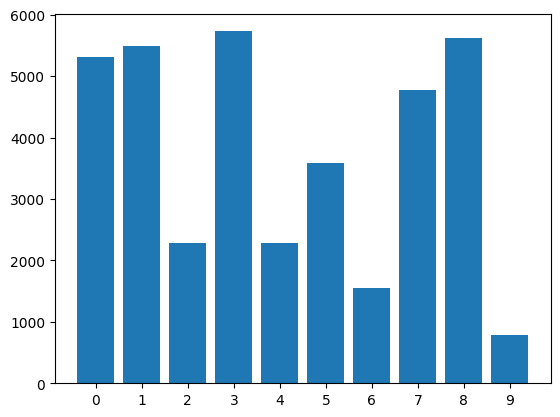

In [ ]:
trainset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

# generate imbalanced dataset
num_classes = 10
torch.manual_seed(seed)
sample_probs = torch.rand(num_classes)

idx_to_remove = [
    idx
    for idx, target in enumerate(train_dataloader.dataset.targets)
    if random.random() > sample_probs[target]  # or target in range(3, 10)
]
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=train_sample, batch_size=64
)
imbalanced_valid_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=valid_sample, batch_size=64
)

### train model on imbalanced dataset

In [ ]:
imbalanced_model, train_losses, val_losses = train(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "Imbalanced_model.pth",
    ConvNet().to(device),
    epochs=40,
)

epoch: 0 [0/117 (0%)]	 training loss: 2.298604
epoch: 0 [10/117 (9%)]	 training loss: 1.588035
epoch: 0 [20/117 (17%)]	 training loss: 1.062984
epoch: 0 [30/117 (26%)]	 training loss: 1.034264
epoch: 0 [40/117 (34%)]	 training loss: 0.727326
epoch: 0 [50/117 (43%)]	 training loss: 0.805709
epoch: 0 [60/117 (51%)]	 training loss: 0.711466
epoch: 0 [70/117 (60%)]	 training loss: 0.667320
epoch: 0 [80/117 (68%)]	 training loss: 0.612479
epoch: 0 [90/117 (77%)]	 training loss: 0.480885
epoch: 0 [100/117 (85%)]	 training loss: 0.550736
epoch: 0 [110/117 (94%)]	 training loss: 0.563295


Validation...

Test dataset: Overall Loss: 0.3820, Overall Accuracy: 25091/37439 (67%)

epoch: 1 [0/117 (0%)]	 training loss: 0.205538
epoch: 1 [10/117 (9%)]	 training loss: 0.637877
epoch: 1 [20/117 (17%)]	 training loss: 0.530392
epoch: 1 [30/117 (26%)]	 training loss: 0.312865
epoch: 1 [40/117 (34%)]	 training loss: 0.515285
epoch: 1 [50/117 (43%)]	 training loss: 0.450202
epoch: 1 [60/117 (51%)]	 trainin

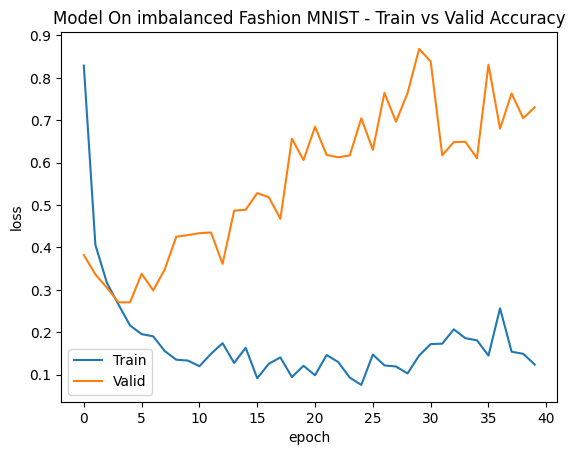

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST - Train vs Valid Accuracy")

plt.show()

### test on test set

In [ ]:
print("On imbalanced Fashion MNIST dataset")
test_acc1, class_percentages1 = test(imbalanced_model, "Imbalanced_model.pth")
print("test accuracy : ", str(test_acc1))

On imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.5755, Overall Accuracy: 8388/10000 (84%)

test accuracy :  83.88


## Augmix image augmentation

In [ ]:
# Adapted from https://github.com/google-research/augmix/blob/master/augmentations.py
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 28


def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .

    Args:
      level: Level of the operation that will be between [0, `PARAMETER_MAX`].
      maxval: Maximum value that the operation can have. This will be scaled to
        level/PARAMETER_MAX.

    Returns:
      An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.

    Args:
      level: Level of the operation that will be between [0, `PARAMETER_MAX`].
      maxval: Maximum value that the operation can have. This will be scaled to
        level/PARAMETER_MAX.

    Returns:
      A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.0


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(
        (IMAGE_SIZE, IMAGE_SIZE),
        Image.AFFINE,
        (1, level, 0, 0, 1, 0),
        resample=Image.BILINEAR,
    )


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(
        (IMAGE_SIZE, IMAGE_SIZE),
        Image.AFFINE,
        (1, 0, 0, level, 1, 0),
        resample=Image.BILINEAR,
    )


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(
        (IMAGE_SIZE, IMAGE_SIZE),
        Image.AFFINE,
        (1, 0, level, 0, 1, 0),
        resample=Image.BILINEAR,
    )


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(
        (IMAGE_SIZE, IMAGE_SIZE),
        Image.AFFINE,
        (1, 0, 0, 0, 1, level),
        resample=Image.BILINEAR,
    )


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast,
    equalize,
    posterize,
    rotate,
    solarize,
    shear_x,
    shear_y,
    translate_x,
    translate_y,
]
augmentations_all = [
    autocontrast,
    equalize,
    posterize,
    rotate,
    solarize,
    shear_x,
    shear_y,
    translate_x,
    translate_y,
    contrast,
    brightness,
    sharpness,
]


def aug(
    image,
    preprocess,
    all_ops=False,
    aug_prob_coeff=1.0,
    mixture_width=3,
    mixture_depth=-1,
    aug_severity=1,
):
    """Perform AugMix augmentations and compute mixture.

    Args:
      image: PIL.Image input image
      preprocess: Preprocessing function which should return a torch tensor.

    Returns:
      mixed: Augmented and mixed image.
    """
    aug_list = augmentations
    if all_ops:
        aug_list = augmentations_all

    ws = np.float32(np.random.dirichlet([aug_prob_coeff] * mixture_width))
    m = np.float32(np.random.beta(aug_prob_coeff, aug_prob_coeff))

    mix = torch.zeros_like(preprocess(image))
    for i in range(mixture_width):
        image_aug = image.copy()
        depth = mixture_depth if mixture_depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(aug_list)
            image_aug = op(image_aug, aug_severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * preprocess(image_aug)

    mixed = (1 - m) * preprocess(image) + m * mix
    return mixed


class AugMixDataset(torch.utils.data.Dataset):
    """Dataset wrapper to perform AugMix augmentation."""

    def __init__(self, dataset, preprocess, no_jsd=True):
        self.dataset = dataset
        self.preprocess = preprocess
        self.no_jsd = no_jsd

    def __getitem__(self, i):
        x, y = self.dataset[i]
        if self.no_jsd:
            return aug(x, self.preprocess), y
        else:
            im_tuple = (
                self.preprocess(x),
                aug(x, self.preprocess),
                aug(x, self.preprocess),
            )
            return im_tuple, y

    def __len__(self):
        return len(self.dataset)

Distribution of classes in Imbalanced dataset:
Counter({3: 5731, 8: 5627, 1: 5497, 0: 5312, 7: 4777, 5: 3579, 2: 2291, 4: 2283, 6: 1549, 9: 793})


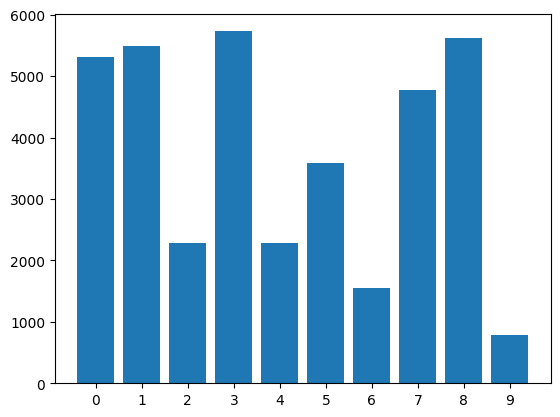

In [ ]:
trainset = datasets.FashionMNIST("../data", train=True, download=True)

imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)

print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

imbalanced_valid_dataset = copy.deepcopy(imbalanced_train_dataset)
imbalanced_valid_dataset.transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
)
imbalanced_valid_dataset = torch.utils.data.Subset(
    imbalanced_valid_dataset, indices[split:]
)

imbalanced_train_dataset = torch.utils.data.Subset(
    imbalanced_train_dataset, indices[:split]
)

preprocess = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
)

imbalanced_train_dataset.transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomCrop(28, padding=1)]
)
imbalanced_valid_dataset.transform = preprocess
imbalanced_train_dataset = AugMixDataset(imbalanced_train_dataset, preprocess)

# Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64
)
imbalanced_valid_loader = torch.utils.data.DataLoader(
    imbalanced_valid_dataset, batch_size=64
)

In [ ]:
imbalanced_model_augmix, train_losses, val_losses = train(
    imbalanced_train_loader,
    imbalanced_valid_loader,
    "Imbalanced_model_augmix.pth",
    ConvNet().to(device),
    epochs=40,
)

epoch: 0 [0/117 (0%)]	 training loss: 2.299308
epoch: 0 [10/117 (9%)]	 training loss: 1.128337
epoch: 0 [20/117 (17%)]	 training loss: 0.710277
epoch: 0 [30/117 (26%)]	 training loss: 0.875652
epoch: 0 [40/117 (34%)]	 training loss: 0.719460
epoch: 0 [50/117 (43%)]	 training loss: 0.771827
epoch: 0 [60/117 (51%)]	 training loss: 0.566613
epoch: 0 [70/117 (60%)]	 training loss: 0.438536
epoch: 0 [80/117 (68%)]	 training loss: 0.738664
epoch: 0 [90/117 (77%)]	 training loss: 0.656614
epoch: 0 [100/117 (85%)]	 training loss: 0.666089
epoch: 0 [110/117 (94%)]	 training loss: 0.531001


Validation...

Test dataset: Overall Loss: 0.4336, Overall Accuracy: 25550/29952 (85%)

epoch: 1 [0/117 (0%)]	 training loss: 0.371202
epoch: 1 [10/117 (9%)]	 training loss: 0.432027
epoch: 1 [20/117 (17%)]	 training loss: 0.461304
epoch: 1 [30/117 (26%)]	 training loss: 0.396159
epoch: 1 [40/117 (34%)]	 training loss: 0.378526
epoch: 1 [50/117 (43%)]	 training loss: 0.438962
epoch: 1 [60/117 (51%)]	 trainin

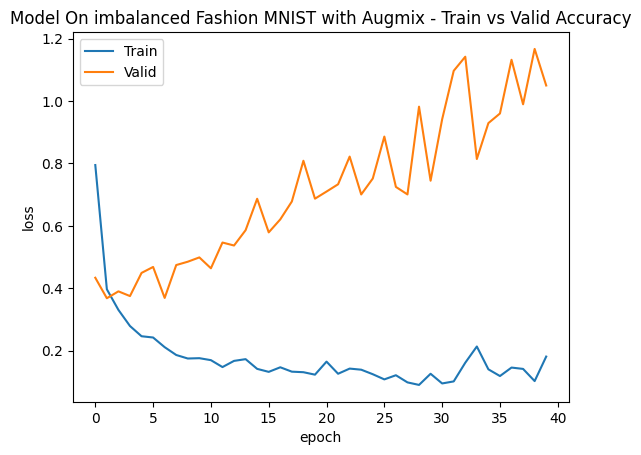

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.title("Model On imbalanced Fashion MNIST with Augmix - Train vs Valid Accuracy")

plt.show()

In [ ]:
print("On imbalanced Fashion MNIST dataset")
test_acc2, class_percentages2 = test(
    imbalanced_model_augmix, "Imbalanced_model_augmix.pth"
)
print("test accuracy : ", str(test_acc2))

On imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.9735, Overall Accuracy: 8402/10000 (84%)

test accuracy :  84.02


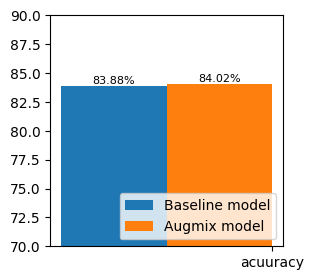

In [ ]:
fig = plt.subplots(figsize=(3, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(br1, np.array(test_acc1).astype(float), width=0.1, label="Baseline model")
p2 = plt.bar(br2, np.array(test_acc2).astype(float), width=0.1, label="Augmix model")

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.xticks([r + 0.15 for r in range(1)], ["acuuracy"])
plt.ylim(70, 90)
plt.legend(loc="lower right")
plt.show()

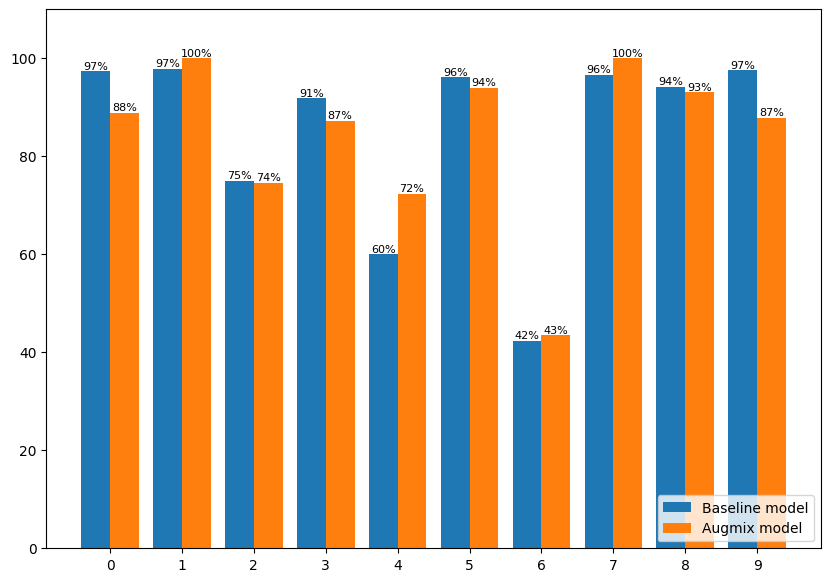

In [ ]:
fig = plt.subplots(figsize=(10, 7))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]

p1 = plt.bar(
    br1,
    np.array(class_percentages1).astype(float) * 100.0,
    width=0.4,
    label="Baseline model",
)
p2 = plt.bar(
    br2,
    np.array(class_percentages2).astype(float) * 100.0,
    width=0.4,
    label="Augmix model",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.0f}%".format(int(height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.0f}%".format(int(height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.xticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.ylim(0, 110)
plt.legend(loc="lower right")
plt.show()